# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
!pip install autograd

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=fe34d119703153559f621ea51ddac8391ef8e42143c9b410f50fbe16b176377c
  Stored in directory: c:\users\paule\appdata\local\pip\cache\wheels\b6\86\a9\2c2d40e3c7d837ca251d7cb66f06a283c8679fa17421e8ddeb
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=63d09775c4bac88fc356460c4b0d52e7d2016f5486a7743afe1098ab5e951d20
  Stored in directory: c:\users\paule\appdata\local\pip\cache\wheels\2f\a0\d3\4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built autograd future


In [2]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

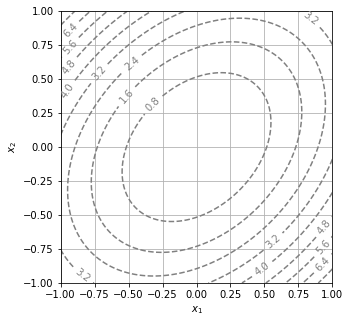

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

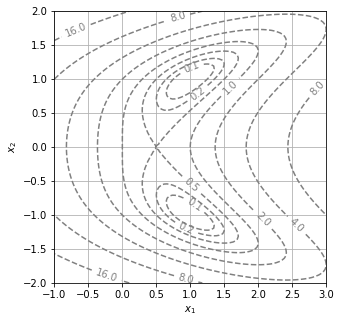

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

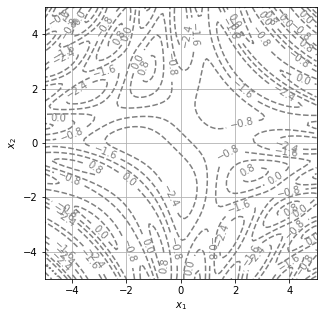

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [39]:
N = 100
eps = 10**(-6)
# epsilon va permettre de vérifier la convergence du modèle de Newton, il faut donc le choisir 
# suffisamment petit pour garantir la précision des résultats. 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    x, y = x0, y0
    vec = np.array([[x], [y]])
    J_F = J(F)
    for _ in range(N): 
        J_inv = np.linalg.inv(J_F(vec[0,0],vec[1,0])) #inverse de la Jacobienne
        vec = vec - np.dot(J_inv, F(vec[0,0],vec[1,0]).T)
        x, y = vec[0,0], vec[1,0]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

0.4472135954999579 0.4472135954999579


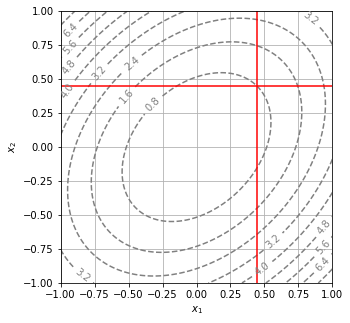

In [111]:
def F1(x, y):
    return np.array([f1(x,y)-0.8, x-y])

xs, ys = Newton(F1, 0.8, 0.8)
print(xs, ys)

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, y, levels=10) # 10 levels, automatically selected

plt.plot(x, [ys for _ in range(100)], 'r')
plt.plot([xs for _ in range(100)], y, 'r')

1.712984870096597 1.712984870096597


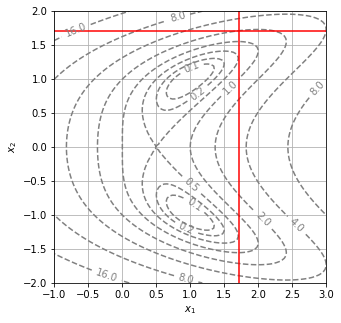

In [114]:
def F2(x, y):
    return np.array([f2(x,y)-2., x-y])

xs, ys = Newton(F2, 1.5, 1.5)
print(xs, ys)


x=np.linspace(-1.0, 3.0, 100)
y=np.linspace(-2.0, 2.0, 100)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(x, [ys for _ in range(100)], 'r')
plt.plot([xs for _ in range(100)], y, 'r')

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [21]:
##Le gradient est orthogonal aux lignes de niveau.
##On propose donc de se décaler de la distance delta par rapport au point (x0,y0)
## orthogonalement par rapport au gradient puis d'appliquer la métode de Newton à partir de ce point.

def point_delta(f, x0, y0, delta):
    c = f(x0, y0)
    v0 = np.array((x0, y0))
    grad_f = grad(f)
    rot = np.array([[0, 1], [-1, 0]]) # matrice de rotation d'angle -PI/2 pour orienter vers la droite du gradient
    vec = np.dot(rot, grad_f(x0,y0).T)
    vec_delta = vec/np.linalg.norm(vec)*delta
    def F(x,y):
        v = np.array((x, y))
        return np.array([f(x,y) - c, np.linalg.norm(v - v0) - delta])
    try :
        return Newton(F, x0 + vec_delta[0], y0 + vec_delta[1])
    except :
        return (x0 + vec_delta[0], y0 + vec_delta[1])


def level_curve(f, x0, y0, delta=0.1, N=100):
    level = [[x0], [y0]]
    for _ in range(N-1):
        x, y = level[0][-1], level[1][-1]
        xn, yn = point_delta(f, x, y, delta)
        level[0].append(xn)
        level[1].append(yn)
    return np.array(level)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [22]:
def level_curve(f, x0, y0, delta=0.1, N=100):
    level = [[x0], [y0]]
    v0 = np.array((x0, y0))
    for j in range(N-1):
        x, y = level[0][-1], level[1][-1]
        xn, yn = point_delta(f, x, y, delta)
        vn = np.array((xn, yn))
        if np.linalg.norm(v0 - vn)<5*delta and j>5: 
            #On arrête le processus si on retourne dans une boule de rayon 5*delta autour de (x0,y0)
            level[0].append(x0)
            level[1].append(y0)
            return np.array(level)
        level[0].append(xn)
        level[1].append(yn)
    return np.array(level)

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

3417


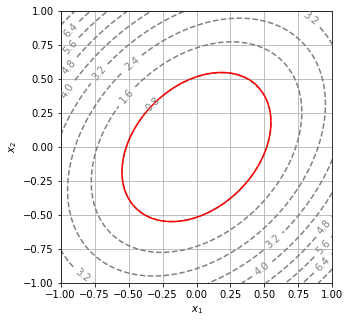

In [107]:
curve_f1 = level_curve(f1, 0.44721, 0.44721, delta = 0.001, N=3500)

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, y, levels=10) # 10 levels, automatically selected

plt.plot(curve[0], curve[1], 'r')

print(len(curve[0]))#Pour vérifier que la condition de non bouclage fonctionne bien (arrêt avant N étapes)

4517


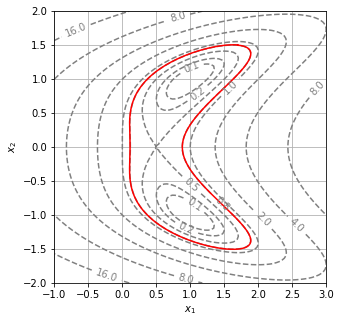

In [108]:
curve = level_curve(f2, 1.7, 1.5, delta = 0.002, N=5000)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=sorted([2**i for i in range(-3, 8)]+[f2(1.7,1.5)]) # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(curve[0], curve[1], 'r')

print(len(curve[0]))

3461


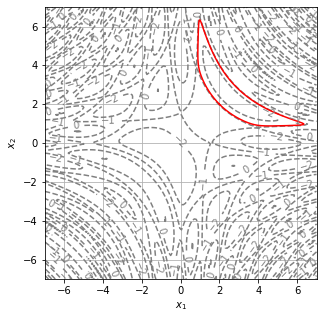

In [109]:
fcurve = level_curve(f3, 2., 2., delta = 0.005, N = 4000)

display_contour(
    f3, 
    x=np.linspace(-7.0, 7.0, 150), 
    y=np.linspace(-7.0, 7.0, 150), 
    levels=4,
)

plt.plot(curve[0], curve[1], 'r')

print(len(curve[0]))

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [23]:
# On choisit un carré centré sur l'origine de côté 5 comme carré initial. 
# On va vérifier que le carré est suffisamment grand pour contenir l'ensemble K en s'assurant que
# tous les petits carrés extérieurs ne sont pas dans K. 

def square_value(f, l, h, i, j):
    '''Renvoie la valeur au milieu du petit carré de coordonnées i,j dans le grand carré de côté l'''
    return f(-l/2 + i*h + h/2, -l/2 + j*h + h/2)

def K_in_square(carre):
    '''Teste si K est bien dans le grand carré'''
    n = len(carre)-1
    if (carre[:, 0] == 0).all() and (carre[:, n] == 0).all() and (carre[0, :] ==0).all() and (carre[n, :] == 0).all():
        return True
    return False

def area_squares(f, c, h):
    l = 3
    Kinsquare = False
    while Kinsquare == False:
        a=0 #compte des petits carrés dans K
        N = int(l//h)
        carre = np.zeros((N,N))# Matrice qui indique si le carré de coordonnées (i,j) est dans K
        for i in range(N):
            for j in range(N):
                if square_value(f, l, h, i, j)<c:
                    a+=1
                    carre[i,j] = 1
        Kinsquare = K_in_square(carre)
        l+=1
    return a*h**2

In [24]:
# Premier test de la fonction
def cercle(x, y):
    '''Fonction dont les lignes de niveau sont des cercles de centre l'origine'''
    return x**2 + y**2

area_squares(cercle, 1., 0.0005)

3.1416

Text(0, 0.5, '|A_h - A|')

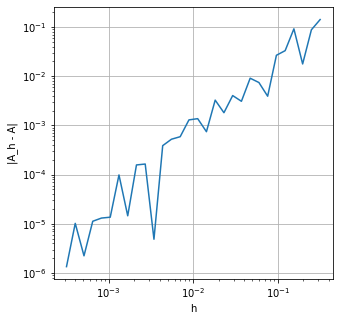

In [25]:
# Tracé de la courbe |A_h - A| en fonction de h.
area_squares_vec = np.vectorize(area_squares)

h_list = 10**np.linspace(-3.5, -0.5, 30)
error = np.abs(area_squares_vec(cercle, 1., h_list)-np.pi)

plt.loglog(h_list, error)
plt.grid(True)
plt.xlabel("h")
plt.ylabel("|A_h - A|")

**L'évolution de l'erreur semble être affine en échelle log-log. On aurait donc une erreur dépendante en h de la forme** $|A_h - A| = 10^b h^c$ **où b est l'ordonnée à l'origine et c le coefficient directeur de la droite. On se propose de faire une régression linéaire pour trouver ce coefficient.**

In [31]:
coeffs = np.polyfit(np.log10(h_list), np.log10(error), 1)
c = coeffs[0]
b = coeffs[1]
print(f"c vaut {c} et b vaut {b}")

c vaut 1.533980135859971 et b vaut -0.13940436351513033


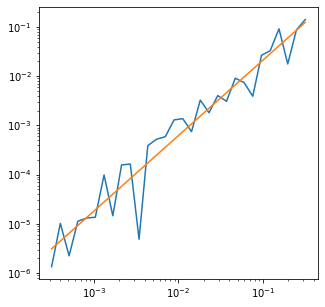

In [32]:
plt.loglog(h_list, error)
plt.loglog(h_list, 10**b*h_list**c)

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [104]:
# Pour obtenir un encadrement de l'aire du domaine K, on peut utiliser la matrice numpy de la fonction
# area_squares pour définir un ensemble de petits carrés strictement inclus dans K et un autre qui contient K.

def corners(f, l, h, i, j):
    corners = 
    
    
    
def encadrement(f, c, epsilon = "pas d'encadrement"):
    l = 2.5
    h = 0.001
    aire_inf = 0
    aire_sup = 2*epsilon
    while aire_sup - aire_inf>epsilon:
        a=0 #compte des petits carrés inclus dans K
        b=0 #compte des petits carrés recouvrant K
        N = int(l//h)
        carre = np.zeros((N,N))# Matrice qui indique si le carré de coordonnées (i,j) est dans K
        for i in range(N):
            for j in range(N):
                if square_value(f, l, h, i, j)<c:
                    carre[i,j] = 1
        print(np.sum(carre))
        for i in range(1,N-1):
            for j in range(1,N-1):
                d = np.sum(np.array([carre[m,n] for m, n in [(i,j),(i,j-1),(i,j+1),(i-1,j),(i+1,j)]]))
                if d==5:
                    # On ajoute la case (i,j) dans le domaine inclus si tous les carrés autour de (i,j) sont dans K
                    a+=1
                    b+=1
                elif d>0:
                    # On ajoute la case (i,j) dans le domaine contenant K si au moins un carré autour de (i,j) est dans K
                    b+=1
        aire_inf = a*h**2
        aire_sup = b*h**2
        print(aire_inf, aire_sup)
        h = h/2
    return aire_inf, aire_sup

In [105]:
encadrement(cercle, 1., 0.01)

3141676.0
3.13602 3.1473359999999997
12566400.0
3.138772 3.1444289999999997


(3.138772, 3.1444289999999997)

**Le programme ci-dessus est très lent, il y a probablement une méthode moins complexe à exploiter ...**

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [89]:
# on prend p = (0,0)
def Bn(N):
    theta = np.linspace(2*np.pi, 0, N)
    C = np.array([np.cos(theta), np.sin(theta)]) # sphère unité
    res = 0
    
    for k in range(N-1):
        zk1, zk = C[:,k+1], C[:, k]
        t = np.array([zk1, zk]).T
        res += np.linalg.det(t)
    return res/2

Bn(10), Bn(100), Bn(1000)

(2.8925442435894273, 3.139484022999947, 3.1415719413758283)

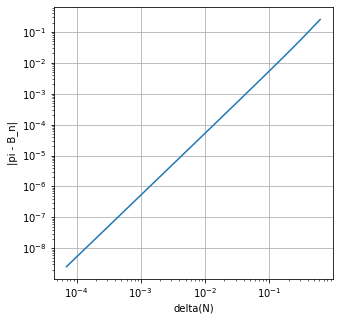

In [116]:
# sin(pi/N) = delta(N)/2 (trigo)

def delta(N): return 2*np.sin(np.pi/N)

N = np.array(list(range(10,100,10))+list(range(100,1000,100))+list(range(1000,10000,1000))
            + list(range(10000,100000,10000)))
x = np.vectorize(delta)(N)
y = np.abs(np.pi - np.vectorize(Bn)(N))


plt.grid(True)
plt.xlabel("delta(N)") 
plt.ylabel("|pi - B_n|")
plt.loglog(x,y)

# remarque : pour des valeurs de N au dela de 10, les courbes obtenues avec delta et avec 2*pi/N en abscisses
# sont quasiment les mêmes

**Comme pour la méthode des carrés, il semble que l'erreur suive une loi affine en échelle log-log. On en déduit que $| \pi - B_n| = 10^{b'} \delta^{c'}$ avec b' l'ordonnée à l'origine et c' le coefficient directeur. On refait une régression linéaire.**

In [119]:
coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
c = coeffs[0]
b = coeffs[1]
print(f"c' vaut {c} et b' vaut {b}")

c' vaut 2.0097439526619114 et b' vaut -0.25040521982714337


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [90]:
# attention : on continue à utiliser le cercle unité
x, y = 3, 2
p = np.array([x,y])

def Bn_p_ext(N):
    theta = np.linspace(2*np.pi, 0, N)
    C = np.array([np.cos(theta), np.sin(theta)]) # sphère unité
    res = 0
    
    for k in range(N-1):
        zk1, zk = C[:,k+1]-p, C[:, k]-p
        t = np.array([zk1, zk]).T
        res += np.linalg.det(t)
    return res/2

# L'aire parcourue par l'algorithme qui n'est pas dans le cercle est parcourue 2 fois : 
# une fois dans le sens positif et une fois dans le sens négatif : ainsi, il ne reste plus à la fin
# que l'aire du disque.

In [91]:
Bn_p_ext(10), Bn_p_ext(100) , Bn_p_ext(1000) 

(2.8925442435894273, 3.139484022999944, 3.141571941375841)

In [92]:
Bn(10), Bn(100) , Bn(1000) 

(2.8925442435894273, 3.139484022999947, 3.1415719413758283)

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [60]:
# on prend l'example de deux disques de rayon 1 et de centres (0,0) et (3,0)
# //!\\ : cette fois il faut que p soit dans K sinon on a un triangle "en trop" (p,z_i,z_i+1), tel que z_i
# appartient au premier disque et z_i+1 au deuxième

def aire_disques(N):
    theta = np.linspace(2*np.pi, 0, N//2)
    C0 = np.array([np.cos(theta), np.sin(theta)]) # sphère unité
    C1 = np.array([np.cos(theta)+3, np.sin(theta)])
    D = np.concatenate((C0,C1), axis=1)
    res = 0
    
    for k in range(N-1):
        zk1, zk = D[:,k+1], D[:, k]
        t = np.array([zk1, zk]).T
        res += np.linalg.det(t)
    res += np.linalg.det(np.array([D[:,-1], D[:,0]]).T)
    return res/2

In [61]:
aire_disques(10), aire_disques(100), aire_disques(1000)

(3.9999999999999987, 6.2659809225407965, 6.2830192782298715)

In [44]:
2*Bn(10), 2*Bn(100) , 2*Bn(1000)

(5.785088487178855, 6.278968045999894, 6.283143882751657)

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [120]:
def area_triangles(x,y):
    """ NB : x et y sont des tableaux lignes """
    Z0 = np.array([0.,0.])
    N = len(x)
    assert N == len(y), 'x et y de longueurs différentes'
    res = 0
    
    for k in range(0,N-1):
        t = np.array([x[k:k+2] - Z0[0], y[k:k+2]] - Z0[1]) 
        res += np.linalg.det(t)
        
    return -res/2

**Test pour la fonction quadratique f1 et la courbe de niveau 0.8 :**

In [121]:
curve_f1 = level_curve(f1, 0.44721, 0.44721, delta = 0.001, N=3500)
aire_tr = area_triangles(curve_f1[0], curve_f1[1])
print(f"Avec la méthode des triangles : {aire_tr}")
aire_ca = area_squares(f1, 0.8, 0.001)
print(f"Avec la méthode des carrés : {aire_ca}")

Avec la méthode des triangles : 0.8909269311248142
Avec la méthode des carrés : 0.888602


**Test pour la fonction f2 avec la courbe de niveau contenant (1.5,1.5) :**

In [122]:
curve_f2 = level_curve(f2, 1.5, 1.5, delta = 0.002, N=5000)
aire_tr = area_triangles(curve_f2[0], curve_f2[1])
print(f"Avec la méthode des triangles : {aire_tr}")
aire_ca = area_squares(f2, f2(1.5, 1.5), 0.01)
print(f"Avec la méthode des carrés : {aire_ca}")

Avec la méthode des triangles : 3.1226774148213567
Avec la méthode des carrés : 3.1102000000000003


**Conclusion :** La méthode des triangles décroît plus vite en erreur par rapport à $\delta$ (erreur en $O(\delta^2))$ que la méthode des carrés par rapport à h (erreur en $O(h^{1.5})$). De plus, la méthode des triangle est de complexité linéaire par rapport à N = $O(\delta^{-1})$, tandis que la méthode des carrés est de complexité quadratique par rapport à N = $O(h^{-1})$. On en déduit que la méthode des triangles est plus efficace. En revanche, la méthode des carrés serait peut-être plus appropriée pour mesurer l'aire d'ensembles non connexes.